### Common Functions

In [1]:
# --- Include files -------------------------------------------------------------------------------
import sys
import csv
import numpy as np
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)
plt.rcParams.update({'font.size': 16})
titlefontsize=25
legendfontsize=20
report_plot=False;

# --- Constants -----------------------------------------------------------------------------------
w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
c = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1], 
              [0, 0, 1, 0, -1, 1, 1, -1, -1]])
#c_op = c[[1,0]]

# --- Functions -----------------------------------------------------------------------------------
calc_rho = lambda f: np.sum(f, axis=0)
calc_vel = lambda f, rho: np.dot(f.T, c[[1,0]].T).T / rho  # 1 contains velocity along y direction and 0 contains velocity along x direction 
calc_neu = lambda omega: (1/3 * (1/omega - 1/2)) 
calc_reynolds = lambda omega, length, vel: (vel * length) / calc_neu(omega)


def f_stream(f):

    for i in range(9):
        f[i,:,:] = np.roll(f[i,:,:], c[:,i], axis=(1,0)) 

    return f                                                                     

def f_equilibrium(rho, vel):

    var1 = np.transpose(vel, (1,0,2))
    var2 = np.transpose(np.dot(c[[1,0]].T, var1), (0,1,2))
    var3 = vel[0,:,:]**2 + vel[1,:,:]**2
    var4 = np.array([rho * w[i] for i in range(9)])

    return (var4 * (1 + 3 * var2 + 9/2 * var2**2 - 3/2 * var3))
    
def f_collision(f, omega):

    rho = calc_rho(f)
    vel = calc_vel(f, rho)
    f_eq = f_equilibrium(rho,vel)
    f = f + omega * (f_eq - f)

    return f, rho, vel, f_eq

def f_moving_wall(f, lid_vel):
 
    w_rho = 2 * (f[6,-2,:] + f[2,-2,:] + f[5,-2,:]) + f[3,-2,:] + f[0,-2,:] + f[1,-2,:]
    f[4, -2, :] = f[2, -2, :]
    f[8, -2, :] = f[6, -2, :] + 6 * w[6] * lid_vel * w_rho
    f[7 ,-2, :] = f[5, -2, :] - 6 * w[5] * lid_vel * w_rho

    return f
    
def f_rigid_wall(f, top, down, left, right):

    if top:
        f[[7,4,8],-2,:] = f[[5,2,6],-1,:]
    if down:
        f[[5,2,6],1,:] = f[[7,4,8],0,:]
    if left:
        f[[8,1,5],:,1] = f[[6,3,7],:,0]
    if right:
        f[[7,3,6],:,-2] = f[[5,1,8],:,-1]

    return f



### Shear Wave Decay Pt 1

NameError: name 'velocity_observe_point' is not defined

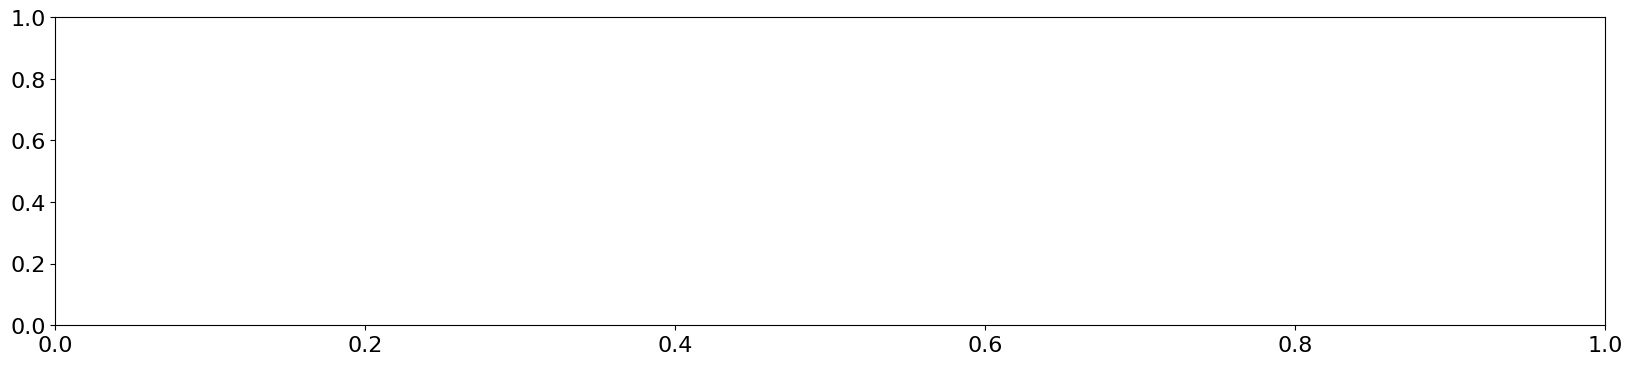

In [2]:
# --- Constants  ----------------------------------------------------------------------------------
steps = 5001
length = 51
width = 51
omega = 1.25
density_observe_point=15

rho_0 = 0.5             
init_fn = lambda i, j: 0.01 * (np.sin(2 * np.pi * i / j))

# --- Simulation Block ----------------------------------------------------------------------------
rho = rho_0 + np.array([[init_fn(x, length) for x in range(length)] for y in range(width)])
vel = np.zeros((2, width, length))

f = f_equilibrium(rho, vel)

s_rho = []
#s_vel = []

for i in range(steps):
    f = f_stream(f)
    f, rho, vel, f_eq = f_collision(f, omega)   
    if i%1 == 0:
        s_rho.append(rho[:,:]) # logging data through iterations
#        s_vel.append(vel[1,velocity_observe_point ,velocity_observe_point]) # logging data through iterations

s_rho = np.array(s_rho)
#s_vel = np.array(s_vel)

# --- Plot Operations -----------------------------------------------------------------------------


# --- PLOT 1 -----------------
fig = plt.figure(figsize=(20,4))
ax =  fig.add_subplot(111)
if report_plot:
        plt.title(r"A [{}, {}] grid at position = [{}, {}] grid with $\omega$ = {}"
              .format(length, width, velocity_observe_point, velocity_observe_point, omega), fontsize=titlefontsize)

else:
    plt.title(r"Density variation in [{}, {}] grid at position = [{}, {}] grid with $\omega$ = {}"
              .format(length, width, velocity_observe_point, velocity_observe_point, omega), fontsize=titlefontsize)
plt.xlabel("iteration")
plt.ylabel("density")
plt.grid(True)
ax.plot(s_rho[:, density_observe_point, density_observe_point], linewidth=3, color='tab:purple') # --- Plot ---  
plt.tight_layout()
plt.savefig('results/plots/m3_density_variation.png', bbox_inches='tight')
plt.show()

# --- PLOT 2 -----------------
i=1
fig = plt.figure(figsize=(20,12))
if report_plot:
        fig.suptitle(r"A [{}, {}] grid at position = [:, {}] with $\omega$ = {}"
                 .format(length, width, density_observe_point, omega), fontsize=titlefontsize)
else:
    fig.suptitle(r"Density variation in [{}, {}] grid at position = [:, {}] with $\omega$ = {}"
                 .format(length, width, density_observe_point, omega), fontsize=titlefontsize)
for itx in range(0, 1480, 185):
        ax = plt.subplot(3,4,i)
        ax.set_title("iteration: {}".format(itx))
        ax.set_xlabel("length")
        ax.set_ylabel("density")
        ax.grid(True)
        ax.set_ylim(0.49,0.51)    
        ax.plot(s_rho[itx, density_observe_point, :], linewidth=3) # --- Plot ---        
        i+=1
        
for itx in range(4250, 5001, 250):
        ax = plt.subplot(3,4,i)
        ax.set_title("iteration: {}".format(itx))
        ax.set_xlabel("length")
        ax.set_ylabel("density")
        ax.grid(True)
        ax.set_ylim(0.49,0.51)    
        ax.plot(s_rho[itx, density_observe_point, :], linewidth=3) # --- Plot ---        
        i+=1
plt.tight_layout()
plt.savefig('results/plots/m3_density_variation1.png', bbox_inches='tight')
plt.show()





### Shear Wave Decay Pt 2


In [ ]:
# --- Constants -----------------------------------------------------------------------------------
steps = 5001
length = 51
width = 51
omega = 1.25
decay_observe_point=25
evolution_observe_point=15
plot3_experimental_result_iteration_point=1000

init_fn = lambda i, j: 0.01 * (np.sin(2 * np.pi * i / j)) # sine function
calc_vel_analytic = lambda omega, t: 0.01*np.exp(-calc_neu(omega)*t*(2*np.pi/length)**2)*(np.sin(2*np.pi*evolution_observe_point/length))
calc_viscosity_simulation = lambda amp_t, amp_0, t: - np.log(amp_t / amp_0) / (t * (2 * np.pi / length) ** 2)

# --- Simulation Block ----------------------------------------------------------------------------
def m3_part2(omega, simulation_ts=None): # placed in function to call for different values of omegas to create PLOT 3
    rho = np.ones((width, length))
    vel = np.zeros((2, width, length))

    vel[1,:,:] = np.array([[init_fn(y, width) for x in range(length)] for y in range(width)]) # creating sine function in velocity
    

    f = f_equilibrium(rho, vel)

    s_velDecay = []
    s_velEvolution = []
    
    for i in range(steps):
        f = f_stream(f)
        f, rho, vel, f_eq = f_collision(f, omega)
        if i%1 == 0:
            s_velDecay.append(vel[1,:,decay_observe_point]) # logging data through iterations
            s_velEvolution.append(vel[1,evolution_observe_point,evolution_observe_point]) # logging data through iterations
    
    s_velDecay = np.array(s_velDecay)
    s_velEvolution = np.array(s_velEvolution)
    
    if(simulation_ts == None):
        return s_velDecay, s_velEvolution
    else:
        return np.max(s_velDecay[simulation_ts,:]), np.max(s_velDecay[0,:])

    

s_velDecay, s_velEvolution = m3_part2(omega)

# --- Plot Operations -----------------------------------------------------------------------------


# --- PLOT 1 -----------------
fig = plt.figure(figsize=(20,5))
ax =  fig.add_subplot(111)
if report_plot:
    plt.title(r"A [{}, {}] grid at position = [{}, {}] with $\omega$ = {}"
              .format(length, width, evolution_observe_point, evolution_observe_point, omega), fontsize=titlefontsize)
else:
    plt.title(r"Velocity variation in [{}, {}] grid at position = [{}, {}] with $\omega$ = {}"
              .format(length, width, evolution_observe_point, evolution_observe_point, omega), fontsize=titlefontsize)

plt.grid(True)
ax.plot(s_velEvolution, linewidth=3, color='tab:purple', label='simulation result') # --- Plot ---  
ax.scatter(np.arange(0, steps,100), calc_vel_analytic(omega, np.arange(0, steps,100)), color='r', s=100, label='analytical result') # --- Scatter ---   
plt.xlabel("iteration")
plt.ylabel(r"velocity $u_x$")
plt.legend(fontsize=legendfontsize)
plt.tight_layout()
plt.savefig('results/plots/m3_velocity_variation.png', bbox_inches='tight')
plt.show()


# --- PLOT 2 -----------------
i=1
fig=plt.figure(figsize=(20,12))
if report_plot:
    fig.suptitle(r"A [{}, {}] grid at position = [{}, :] with $\omega$ = {} "
                 .format(length, width, decay_observe_point, omega), fontsize=titlefontsize)
else:
    fig.suptitle(r"Velocity variation in [{}, {}] grid at position = [{}, :] with $\omega$ = {} "
                 .format(length, width, decay_observe_point, omega), fontsize=titlefontsize)

for itx in range(0, 2000, 250):
        ax = plt.subplot(3,4,i)
        ax.grid(True)
        ax.set_title("iteration: {}".format(itx))
        ax.set_ylabel(r"velocity $u_x$")
        ax.set_xlabel("width")
        ax.set_ylim(-0.01, 0.01)
        ax.plot(s_velDecay[itx,:], linewidth=3) # --- Plot ---  
        i+=1

for itx in range(4250, 5001, 250):
        ax = plt.subplot(3,4,i)
        ax.grid(True)
        ax.set_title("iteration: {}".format(itx))
        ax.set_ylabel(r"velocity $u_x$")
        ax.set_xlabel("width")
        ax.set_ylim(-0.01, 0.01)
        ax.plot(s_velDecay[itx,:], linewidth=3) # --- Plot ---  
        i+=1

plt.tight_layout()
plt.savefig('results/plots/m3_velocity_variation1.png', bbox_inches='tight')
plt.show()


# --- PLOT 3 -----------------
omega_array_analytical = np.arange(0.1, 2, 0.01)
viscosity_array_analytical = (1 / omega_array_analytical - 1 / 2) / 3


omega_array_simulation = np.arange(0, 2, 0.1)
viscosity_array_simulation = []

for omega in omega_array_simulation:
    amp_t, amp_0 = m3_part2(omega, simulation_ts = plot3_experimental_result_iteration_point)
    viscosity_array_simulation.append(calc_viscosity_simulation(amp_t, amp_0, plot3_experimental_result_iteration_point))
viscosity_array_simulation = np.array(viscosity_array_simulation)

#plt.figure(figsize=(10,10))
plt.title(r"Influence of $\omega$ on $\nu$", fontsize=titlefontsize-10)
plt.xlabel(r"omega ($\omega$)")
plt.ylabel(r"viscosity ($\nu$)")
plt.grid(True)

analytical, = plt.plot(omega_array_analytical, viscosity_array_analytical, linewidth=3, color='r') # --- Plot ---  
simulation = plt.scatter(omega_array_simulation , viscosity_array_simulation, color='tab:purple', s=30) # --- Scatter ---   
simulation1, = plt.plot(omega_array_simulation , viscosity_array_simulation, color='tab:purple', linestyle='--', linewidth=3) # --- Plot ---  
plt.legend([analytical, (simulation, simulation1)], ['analytical result', 'simulation result'], scatteryoffsets=[0.5], fontsize=legendfontsize-10)
plt.savefig('results/plots/m3_omega_vs_viscosity.png', bbox_inches='tight')
plt.show()




### Couette Flow


In [ ]:
# --- Constants -----------------------------------------------------------------------------------
steps = 20001
length = 51 + 2
width = 51 + 2
lid_vel = 0.2
omega = 1.25
observe_point = 25
#--- Simulation Block -----------------------------------------------------------------------------
rho = np.ones((width, length))
vel = np.zeros((2, width, length))
s_vel = []

f = f_equilibrium(rho, vel)

for i in range(steps):
    f = f_stream(f)
    f = f_rigid_wall(f, False, True, False, False)
    f = f_moving_wall(f, lid_vel)
    f, rho, vel, f_eq = f_collision(f, omega)
    if i%1==0:
        s_vel.append(vel[1,1:-1,observe_point]) # logging data through iterations
    
s_vel = np.array(s_vel)     


# --- Plot Operations -----------------------------------------------------------------------------


# --- PLOT 1 ---------------------
i=1
fig=plt.figure(figsize=(20,12))
if report_plot:
    fig.suptitle(r"A [{},{}] grid at position = [{}, :] with $\omega$ = {} and $U_w$ = {}"
                 .format(length-2, width-2, observe_point, omega, lid_vel), fontsize=titlefontsize)
else:
    fig.suptitle(r"Couette flow in [{},{}] grid at position = [{}, :] with $\omega$ = {} and $U_w$ = {}"
                 .format(length-2, width-2, observe_point, omega, lid_vel), fontsize=titlefontsize)

for itx in range(1000, 8001, 1000):
        ax = plt.subplot(3,4,i)
        ax.grid(True)
        ax.set_title("iteration: {}".format(itx))
        ax.set_xlabel(r"velocity $u_x$")
        ax.set_ylabel("width")
        simulation, = ax.plot(s_vel[itx,:], np.arange(0, width-2), linewidth=3) # --- plot ---  
        analytical, = ax.plot([0.00197848,0.2],[0,50], color='r', linestyle='--', linewidth=3) # --- plot ---  
        fixed_wall = ax.axhline(y=0, color='g', linestyle='--', linewidth=3) # --- axhline ---
        moving_wall = ax.axhline(y=50, color='g', linestyle='-', linewidth=3) # --- axhline ---
        arrow = ax.scatter([0.025, 0.075, 0.125, 0.175], [50, 50, 50, 50], marker='>', color='g', s=100) # --- scatter ---
        i+=1
        
for itx in range(18000, 20001, 1000):
        ax = plt.subplot(3,4,i)
        ax.grid(True)
        ax.set_title("iteration: {}".format(itx))
        ax.set_xlabel(r"velocity $u_x$")
        ax.set_ylabel("width")
        simulation, = ax.plot(s_vel[itx,:], np.arange(0, width-2), linewidth=3) # --- plot ---  
        analytical, = ax.plot([0.00197848,0.2],[0,50], color='r', linestyle='--', linewidth=3) # --- plot ---  
        fixed_wall = ax.axhline(y=0, color='g', linestyle='--', linewidth=3) # --- axhline ---
        moving_wall = ax.axhline(y=50, color='g', linestyle='-', linewidth=3) # --- axhline ---
        arrow = ax.scatter([0.025, 0.075, 0.125, 0.175], [50, 50, 50, 50], marker='>', color='g', s=100) # --- scatter ---
        i+=1

plt.tight_layout()
fig.legend([simulation, analytical, fixed_wall, (moving_wall,arrow)],
           ['simulation result','analytical result', 'fixed wall', 'moving wall towards \n right side with \n'+ r' $U_w$ velocity'], 
           loc=(0.77,0.08), fontsize=legendfontsize, scatteryoffsets=[0.5])
plt.savefig('results/plots/m4_couette_flow.png', bbox_inches='tight')
plt.show()



### Poiseuille Flow

In [ ]:
# --- Constants -----------------------------------------------------------------------------------
steps = 20001
length = 51 + 2
width = 51 + 2
omega = 0.88
pressure_difference = 0.02
observe_point = 25 #slice point in grid to plot data from

# --- Simulation Block ----------------------------------------------------------------------------
rho_in = np.ones((width, length)) + pressure_difference/2 # rho with input pressure gradient
rho_out = np.ones((width, length)) - pressure_difference/2 # rho with output pressure gradient
vel = np.zeros((2, width, length))

f = f_equilibrium(rho_in, vel)

vels_x = []
rhos_x = []

for i in range(steps):
    f = f_stream(f) 
    f = f_rigid_wall(f, True, True, False, False)
    f, rho, vel, f_eq = f_collision(f, omega)
    f[:,1:-1, 0] = f_equilibrium(rho_in, vel)[:,1:-1,-2] + (f[:,1:-1,-2] - f_eq[:,1:-1,-2])
    f[:,1:-1,-1] = f_equilibrium(rho_out, vel)[:,1:-1, 1] + (f[:,1:-1, 1] - f_eq[:,1:-1, 1])
   
    if i%1==0:
        vels_x.append(vel[1,1:-1,observe_point]) # logging data through iterations
        rhos_x.append(rho[width//2,1:-1]) # logging data through iterations
        
vels_x = np.array(vels_x)
rhos_x = np.array(rhos_x)

# --- Plot Operations -----------------------------------------------------------------------------
i=1
fig=plt.figure(figsize=(20,12))
if report_plot:
    fig.suptitle(r"A [{}, {}] grid at position = [{}, :] with $\omega$ = {} and $\Delta p$ = {}"
                 .format(length-2, width-2, observe_point, omega, pressure_difference), fontsize=titlefontsize)
else:
    fig.suptitle(r"Poiseuille flow in [{}, {}] grid at position = [{}, :] with $\omega$ = {} and $\Delta p$ = {}"
                 .format(length-2, width-2, observe_point, omega, pressure_difference), fontsize=titlefontsize)

nu_no = lambda omega: (1/3 * (1/omega - 1/2))
analytic = lambda omega, y: -(1/(2*1*nu_no(omega)) * 0.02 * y * (50 - y)) - 0.00686819
y = np.arange(51);
u = analytic(0.01 * omega, y)

# --- PLOT 1 --------------------
for itx in range(1000, 6000, 625):
        ax = plt.subplot(3,4,i)
        ax.grid(True)
        ax.set_title("iteration: {}".format(itx))
        ax.set_xlabel(r"velocity $u_x$")
        ax.set_ylabel("width")
        simulation, =  ax.plot(vels_x[itx,:], np.arange(0, width - 2), linewidth=3)        
        analytical, = ax.plot(abs(u), np.arange(51), color='r', linestyle='--', linewidth=3)
        fixed_wall = ax.axhline(y=50, color='g', linestyle='--', linewidth=3)
        fixed_wall = ax.axhline(y=0, color='g', linestyle='--', linewidth=3)
        i+=1

for itx in range(19500, 20001, 250):
        ax = plt.subplot(3,4,i)
        ax.grid(True)
        ax.set_title("iteration: {}".format(itx))
        ax.set_xlabel(r"velocity $u_x$")
        ax.set_ylabel("width")
        simulation, =  ax.plot(vels_x[itx,:], np.arange(0, width - 2), linewidth=3)        
        analytical, = ax.plot(abs(u), np.arange(51), color='r', linestyle='--', linewidth=3)
        fixed_wall = ax.axhline(y=50, color='g', linestyle='--', linewidth=3)
        fixed_wall = ax.axhline(y=0, color='g', linestyle='--', linewidth=3)
        i+=1
fig.legend([simulation, analytical, fixed_wall],['simulation result','analytical result', 'fixed wall'], loc=(0.77,0.1), fontsize=legendfontsize)
plt.tight_layout()
plt.savefig('results/plots/m5_poiseuille_flow.png', bbox_inches='tight')
plt.show()

# --- PLOT 2 ----------------------
i=1
fig=plt.figure(figsize=(20,4))
if report_plot:
    fig.suptitle(r"At position = [:,{}] with $\Delta p$ = {}"
                .format(width//2, pressure_difference), fontsize=titlefontsize, y=0.94)
else:
    fig.suptitle(r"$\At position = [:,{}] Delta p$ = {} produced through density variation in poiseuille flow grid"
                .format(width//2, pressure_difference), fontsize=titlefontsize, y=0.94)
for itx in range(1000, 20000, 6000):
        ax = plt.subplot(1,4,i)
        ax.grid(True)
        ax.set_title("iteration: {}".format(itx))
        ax.set_xlabel("length")
        ax.set_ylabel("density")
        ax.plot(np.arange(0, length - 2), rhos_x[itx, :], linewidth=3, color='tab:orange')
        i+=1
        
plt.tight_layout()
plt.savefig('results/plots/m5_pressure_gradient.png', bbox_inches='tight')
plt.show()


### Sliding Lid

In [ ]:
# --- Constants -----------------------------------------------------------------------------------
steps = 20001
length =100 + 2
width = 100 + 2
omega = 1.6
lid_vel = 0.2

# --- Simulation Block ----------------------------------------------------------------------------
rho = np.ones((width, length))
vel = np.zeros((2,width, length))

vel_x = []
vel_y = []

f = f_equilibrium(rho, vel)

for i in range(steps):
    
    f = f_stream(f)
    f = f_rigid_wall(f, False, True, True, True) 
    f = f_moving_wall(f, lid_vel) 
    f, rho, vel,f_eq = f_collision(f, omega)
    
    if i%1==0:
        vel_x.append(vel[1,1:-1,1:-1]) # logging data through iterations
        vel_y.append(vel[0,1:-1,1:-1]) # logging data through iterations
        
vel_x = np.array(vel_x)
vel_y = np.array(vel_y)


# --- Plot Operations -----------------------------------------------------------------------------


# --- PLOT 1 ---------------------
i=1
fig=plt.figure(figsize=(20,12))
if report_plot:
    fig.suptitle(r"A [{}, {}] grid with $\omega$ = {}, $U_w$ = {} and Re = {}"
                 .format(length-2, width-2, omega, lid_vel, calc_reynolds(omega, length, lid_vel)), fontsize=titlefontsize)
else:
    fig.suptitle(r"Serial operating sliding lid in [{}, {}] grid with $\omega$ = {}, $U_w$ = {} and Re = {}"
                 .format(length-2, width-2, omega, lid_vel, calc_reynolds(omega, length, lid_vel)), fontsize=titlefontsize)
for itx in range(1000, 12001, 1000):
        if itx == 12000: break
        ax = plt.subplot(3,4,i)
        ax.set_title("iteration: {}".format(itx))
        ax.set_xlabel("length")
        ax.set_ylabel("width")
        ax.set_xlim(0,length - 2)
        ax.set_ylim(0,width - 2)
        ax.streamplot(np.arange(0, length - 2), np.arange(0,width - 2), vel_x[itx], vel_y[itx], arrowsize=1, linewidth=1.5) # --- streamplot ---
        arrow = ax.scatter([20, 40, 60, 80], [100.5, 100.5, 100.5, 100.5], marker='>', color='g', s=100, clip_on=False) # --- scatter ---
        moving_wall = ax.axhline(y=100.5, color='g', linestyle='-', linewidth=3, clip_on=False) # --- axhline ---
        fixed_wall = ax.axhline(y=-0.5, color='g', linestyle='--', linewidth=3, clip_on=False) # --- axhline ---
        fixed_wall = ax.axvline(x=100.5, color='g', linestyle='--', linewidth=3, clip_on=False) # --- axvline ---
        fixed_wall = ax.axvline(x=-0.5, color='g', linestyle='--', linewidth=3, clip_on=False) # --- axvline ---
        i+=1

fluid_line = mlines.Line2D([], [], linewidth=3)
fluid_arrow = mlines.Line2D([], [], marker='>', linestyle='None',  markersize=10)
fig.legend([(fluid_line,fluid_arrow), fixed_wall, (moving_wall, arrow)],
           ['fluid stream','fixed wall', 'moving wall towards \n right side with \n'+ r' $U_w$ velocity'], 
           loc=(0.77,0.1), fontsize=legendfontsize, scatteryoffsets=[0.5])

plt.tight_layout()
plt.savefig('results/plots/m6_sliding_lid.png', bbox_inches='tight')
plt.show()




### Milestone 7 Parallel runs velocity plotter

In [ ]:
# --- Constants -----------------------------------------------------------------------------------
lid_vel = 0.1
omega = 1.6

# import os
# cwd = os.getcwd()
# print(cwd)

calc_neu = lambda omega: (1/3 * (1/omega - 1/2)) 
calc_reynolds = lambda omega, length, vel: (vel * length) / calc_neu(omega)

ux = []
uy = []

# --- data reading block ---------------------------------------------------------------------------
for i in range(0, 99001, 1000):
    ux.append(np.load('results/m7_plot_data/grid_600_decomp_10_ux_{}.npy'.format(i)))
    uy.append(np.load('results/m7_plot_data/grid_600_decomp_10_uy_{}.npy'.format(i)))
    
ux = np.array(ux)
uy = np.array(uy)

print("the shape of acquired array is")
print(ux.shape)
nx, ny = ux[1,:,:].shape


# --- Plot Operations -----------------------------------------------------------------------------
# --- PLOT 1 ---------------------
i=1
fig=plt.figure(figsize=(20,12))
if report_plot:
    fig.suptitle(r"A [{}, {}] grid with [10, 10] processes, $\omega$ = {}, $U_w$ = {} and Re = {}"
                 .format(nx, ny, omega, lid_vel, calc_reynolds(omega, nx, lid_vel)), fontsize=titlefontsize)
else:
    fig.suptitle(r"Parallelized sliding lid in [{}, {}] grid with [10, 10] processes, $\omega$ = {}, $U_w$ = {} and Re = {}"
                 .format(nx, ny, omega, lid_vel, calc_reynolds(omega, nx, lid_vel)), fontsize=titlefontsize)

for itx in range(11, 110, 9):
        if itx == 101: itx = 99
        ax = plt.subplot(3,4,i)
        ax.set_title("iteration: {}".format(itx * 1000))
        ax.set_xlabel("length")
        ax.set_ylabel("width")
        ax.set_xlim(0,nx)
        ax.set_ylim(0,ny)
        ax.streamplot(np.arange(0, nx), np.arange(0,ny), ux[itx], uy[itx], linewidth=1.5, arrowsize=1) # ---streamplot ---
        arrow = ax.scatter([120, 240, 360, 480], [603, 603, 603, 603], marker='>', color='g', s=100, clip_on=False) # --- scatter ---
        moving_wall = ax.axhline(y=603, color='g', linestyle='-', linewidth=3, clip_on=False) # --- axhline ---
        fixed_wall = ax.axhline(y=-3, color='g', linestyle='--', linewidth=3, clip_on=False) # --- axhline ---
        fixed_wall = ax.axvline(x=603, color='g', linestyle='--', linewidth=3, clip_on=False) # --- axvline ---
        fixed_wall = ax.axvline(x=-3, color='g', linestyle='--', linewidth=3, clip_on=False) # --- axvline ---
        i+=1

fluid_line = mlines.Line2D([], [], linewidth=3)
fluid_arrow = mlines.Line2D([], [], marker='>', linestyle='None',  markersize=10)
fig.legend([(fluid_line,fluid_arrow), fixed_wall, (moving_wall, arrow)],
           ['fluid stream','fixed wall', 'moving wall towards \n right side with \n'+ r' $U_w$ velocity'], 
           loc=(0.77,0.1), fontsize=legendfontsize, scatteryoffsets=[0.5])

plt.tight_layout()
plt.savefig('results/plots/m7_sliding_lid.png', bbox_inches='tight')
plt.show()


### Log Log Plot

In [ ]:
rows_600 = []
with open("results/mlups_plot_data/results_600.out", 'r') as file:
    csvreader = csv.reader(file, delimiter='\t')
    header = next(csvreader)
    for row in csvreader:
        if row == []:
            break
        rows_600.append(row)


rows_500 = []
with open("results/mlups_plot_data/results_500.out", 'r') as file:
    csvreader = csv.reader(file, delimiter='\t')
    header = next(csvreader)
    for row in csvreader:
        if row == []:
            break
        rows_500.append(row)


rows_400 = []
with open("results/mlups_plot_data/results_400.out", 'r') as file:
    csvreader = csv.reader(file, delimiter='\t')
    header = next(csvreader)
    for row in csvreader:
        if row == []:
            break
        rows_400.append(row)


rows_100_300 = []
with open("results/mlups_plot_data/results_100-300.out", 'r') as file:
    csvreader = csv.reader(file, delimiter='\t')
    header = next(csvreader)
    for row in csvreader:
        if row == []:
            break
        rows_100_300.append(row)
        
rows_100_300 = np.array(rows_100_300, dtype=float)
rows_100 = rows_100_300[:6]
rows_200 = rows_100_300[6:13]
rows_300 = rows_100_300[13:23]
rows_400 = np.array(rows_400, dtype=float)
rows_500 = np.array(rows_500, dtype=float)
rows_600 = np.array(rows_600, dtype=float)


# --- PLOT 1 ---------------------
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
if not report_plot:
    fig.suptitle("Comparison of performance gain for different grid sizes from parallel operating sliding lid simulation", 
                 fontsize=titlefontsize)
plt.xlabel("number of parallel processes")
plt.ylabel("MLUPS")
plt.grid(True, which="both", ls="-")
plt.figure(figsize=(10,5)) 

ax.set_xscale("log", base=2)
ax.set_yscale("log", base=10)

ax.plot(rows_100[:,2], rows_100[:,6], label='[100, 100] grid', linewidth=2)
ax.plot(rows_200[:,2], rows_200[:,6], label='[200, 200] grid', linewidth=2)
ax.plot(rows_300[:,2], rows_300[:,6], label='[300, 300] grid', linewidth=2)
ax.plot(rows_400[:,2], rows_400[:,6], label='[400, 400] grid', linewidth=2)
ax.plot(rows_500[:,2], rows_500[:,6], label='[500, 500] grid', linewidth=2)
ax.plot(rows_600[:,2], rows_600[:,6], label='[600, 600] grid', linewidth=2)

ax.scatter(rows_100[:,2], rows_100[:,6], s=100)
ax.scatter(rows_200[:,2], rows_200[:,6], s=100)
ax.scatter(rows_300[:,2], rows_300[:,6], s=100)
ax.scatter(rows_400[:,2], rows_400[:,6], s=100)
ax.scatter(rows_500[:,2], rows_500[:,6], s=100)
ax.scatter(rows_600[:,2], rows_600[:,6], s=100)

ax.legend(fontsize=legendfontsize)
plt.tight_layout()
fig.savefig('results/plots/m7_log_log_plot.png', bbox_inches='tight')
plt.show()


In [ ]:
a = 10
b = 51 // 2
c,d=a, b
d